# Removing annual and semi-annual signals from a time series using a least squares approach

It is often the case that seasonal signals and trends can hide the signal of interest in time series in the earth sciences.  Here I show a simple method for removing these signals using a least squares solution.  While this may not always be the best method for deseasoning, it is ideal when the annual / semi-annual signals are approximately sinusoidal.

### Test data
The example data set we will use for this analysis is mass change on the periphery of the Greenland ice sheet as measured by the GRACE satellites and processed by Goddard Spaceflight Center.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
%matplotlib inline

Lets load in the data and plot it up to see what we are dealing with

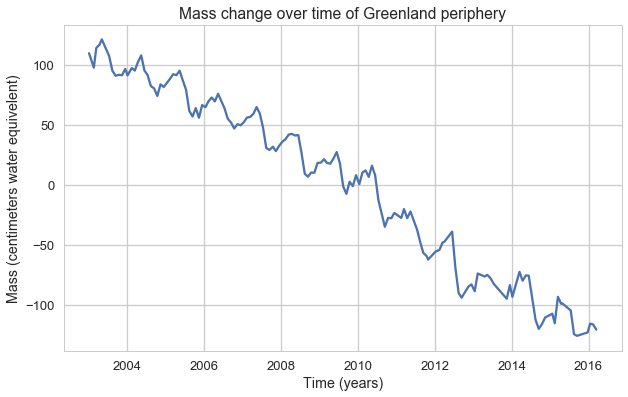

In [2]:
data = np.genfromtxt('grace_data.txt', skip_header = 10, delimiter=',')
t = data[:, 0]
mass = data[:, 1]

plt.figure(figsize=(10,6))
plt.plot(t, mass)
plt.xlabel('Time (years)')
plt.ylabel('Mass (centimeters water equivelent)')
plt.title('Mass change over time of Greenland periphery')

As we can see the periphery has been losing a lot of mass! There is a strong annual signal and trend with potentially a minor semi-annual signal as well.  Lets see if we can remove these to better understand the interannual variability.

## Least squares theory
Following Tarantola (2005), the general least squares problem can be simply described as 
\begin{equation}
\bar{G}m = \bar{d}
\end{equation}
Where  $\bar{G}$ is a vector of partials of the model, $\bar{y}$, with respect to time, m is a vector of model parameters  and $\bar{d}$ is the vector of observed data which is the mass change data in our case.  

A simple model with seasonal signals and a trend  can be described as 

\begin{equation}
\begin{split}
\bar{y}(t) = a_{1} + a_{2}t + a_{3}*cos(2 \pi f_{1} t) + \\ a_{4}*sin(2 \pi f_{1} t) + a_{5}*cos(2 \pi f_{2} t) + \\ a_{6}*sin(2 \pi f_{2} t)
\end{split}
\end{equation}


Where  t is time, $a_{i}$ are the model parameters, and $f_{1}$ and $f_{2}$ are the annual and semi-annual signal frequencies respectively (here taken to be 1 cycle/year and 2 cycles/year).  The G matrix is therefore described  as 
\begin{equation}
\begin{split}
\bar{G} =  \frac{\partial \bar{y}}{\partial a} =  [1, t, cos(2 \pi f_{1} t), \\ sin(2 \pi f_{1} t), cos(2 \pi f_{2} t), \\ sin(2 \pi f_{2} t)]
\end{split}
\end{equation}

This ends up looking like...

In [3]:
G = np.matrix([np.ones(len(t)), t, 
               np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 
               np.cos(4 * np.pi * t), np.sin(4 * np.pi * t)]).T


The model fit parameters, m, can then be determined as 

\begin{equation}
m = (\bar{G}^{T}\bar{G})^{-1}\bar{G}^{T}\bar{d}
\end{equation}

In [4]:
mass = np.matrix(mass).T  # Change dimension and change to a matrix 
m = np.linalg.inv(G.T*G) * G.T * mass

And the forward model, $\bar{y}_{fwd}$, solved as 

\begin{equation}
\bar{y}_{fwd} = \bar{G}m
\end{equation}

In [5]:
fwd = G * m

## Results of forward model
We can then see how our forward model turned out.

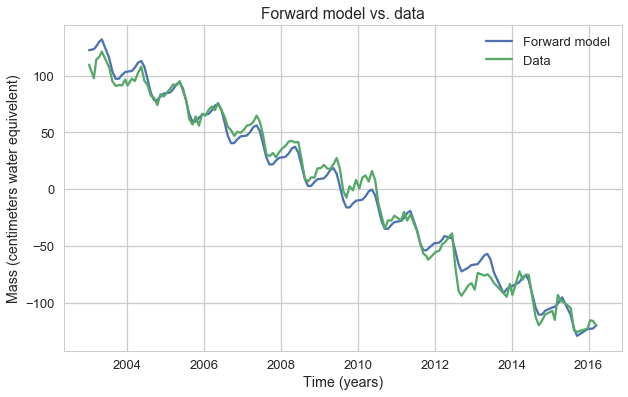

In [6]:
plt.figure(figsize=(10,6))
plt.plot(t, fwd, label='Forward model')
plt.plot(t, mass, label='Data')
plt.xlabel('Time (years)')
plt.ylabel('Mass (centimeters water equivelent)')
plt.title('Forward model vs. data')
plt.legend(loc='upper right')

It looks like our forward model did a really good job of modeling the data with only two sinusoids, a trend, and a scaler term!  Now lets subtract the model from the data to see the residual signal.

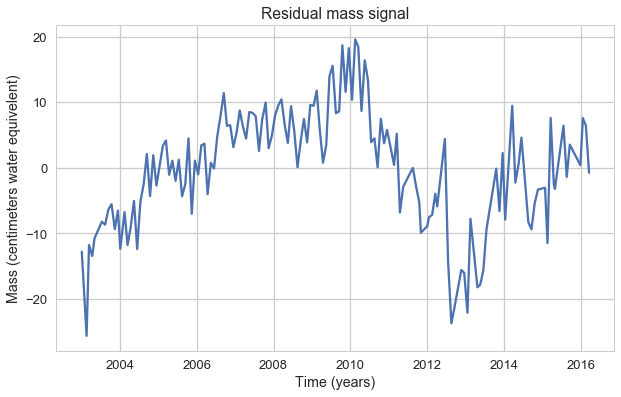

In [7]:
plt.figure(figsize=(10,6))
plt.plot(t, mass - fwd)
plt.xlabel('Time (years)')
plt.ylabel('Mass (centimeters water equivelent)')
plt.title('Residual mass signal')

Removing the seasonality and trend terms allow us to get a more detailed look at which years experienced the highest melt rates.  We must remember that we subtracted a constant term and trend as well with our forward model so our residuals are currently zero mean.  We can see that 2010 was a relatively higher than average melt year and there was a significant dip around 2013. These signals were not visible in our original plot of the time series because of the high amplitude seasonal signal.

We can add back in the trend and scaler terms below

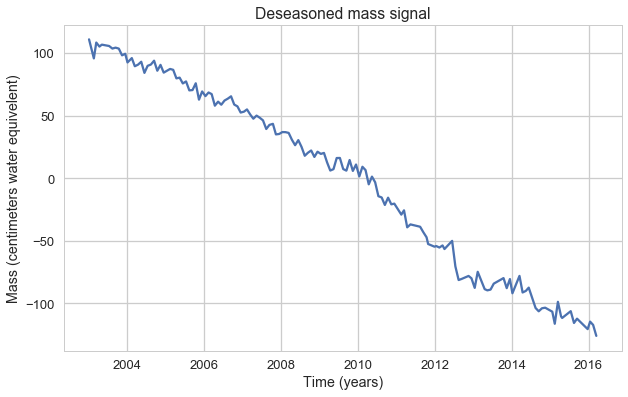

In [8]:
trend_scale = G[:, 0:2] * m[0:2, :]

plt.figure(figsize=(10,6))
plt.plot(t, (mass-fwd) + trend_scale)
plt.xlabel('Time (years)')
plt.ylabel('Mass (centimeters water equivelent)')
plt.title('Deseasoned mass signal')